# Регуляризация и валидация моделей 

*подготовил Пиле Ян*

# Валидация моделей

При построении моделей машинного обучения часто наша основная задача в том, чтобы научиться предсказывать значение целевой переменной на новых данных. Это будет получаться в том случае, когда у модели хорошая обобщающая способность, то есть при обучении вы смогли "отловить" часть "истинной взаимосвязи" между переменными и таргетом и с помощью этой взаимосвязи можете строить прогнозы на новых данных. Как понять, что у вашей модели хорошая обобщающая способность? Надо сымитировать ситуацию с "новыми данными" и проверить модель на них. Мы с вами уже так делали.

## Разбираем все сразу на примере

У нас есть данные 150 тысяч отзывов на вино. Попробуем предсказать по тексту отзыва и типу вина его оценку по стобалльной шкале.

In [230]:
import pandas as pd
import numpy as np
import warnings
import matplotlib.pyplot as plt

warnings.filterwarnings("ignore") 

df = pd.read_csv("winemag-data_first150k.csv", index_col = 0)

In [232]:
x = pd.read_csv('https://raw.githubusercontent.com/pileyan/Data/master/data/babies%20names/babies_all.txt', 
               index_col = 0)

In [233]:
x

,name,sex,number,year
0,Mary,F,7065,1880
1,Anna,F,2604,1880
2,Emma,F,2003,1880
3,Elizabeth,F,1939,1880
4,Minnie,F,1746,1880
...,...,...,...,...
33833,Zymaire,M,5,2010
33834,Zyonne,M,5,2010
33835,Zyquarius,M,5,2010
33836,Zyran,M,5,2010


In [59]:
df.head(3)

,country,description,designation,points,price,province,region_1,region_2,variety,winery
0,US,This tremendous 100% varietal wine hails from ...,Martha's Vineyard,96,235.0,California,Napa Valley,Napa,Cabernet Sauvignon,Heitz
1,Spain,"Ripe aromas of fig, blackberry and cassis are ...",Carodorum Selección Especial Reserva,96,110.0,Northern Spain,Toro,NaN,Tinta de Toro,Bodega Carmen Rodríguez
2,US,Mac Watson honors the memory of a wine once ma...,Special Selected Late Harvest,96,90.0,California,Knights Valley,Sonoma,Sauvignon Blanc,Macauley


In [60]:
print(df.shape)
print(df.points.agg(['min','max']))

(150930, 10)
min     80
max    100
Name: points, dtype: int64


## EDA

### Распределение оценок выглядит нормально

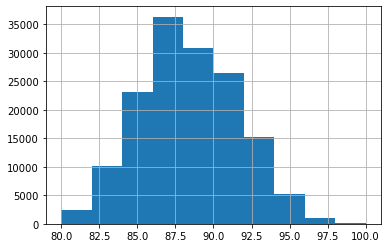

In [61]:
df.points.hist()

### Обработаем пропуски

In [62]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 150930 entries, 0 to 150929
Data columns (total 10 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   country      150925 non-null  object 
 1   description  150930 non-null  object 
 2   designation  105195 non-null  object 
 3   points       150930 non-null  int64  
 4   price        137235 non-null  float64
 5   province     150925 non-null  object 
 6   region_1     125870 non-null  object 
 7   region_2     60953 non-null   object 
 8   variety      150930 non-null  object 
 9   winery       150930 non-null  object 
dtypes: float64(1), int64(1), object(8)
memory usage: 12.7+ MB


In [63]:
df = df.dropna(axis=0, subset=['country'])

In [64]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 150925 entries, 0 to 150929
Data columns (total 10 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   country      150925 non-null  object 
 1   description  150925 non-null  object 
 2   designation  105190 non-null  object 
 3   points       150925 non-null  int64  
 4   price        137230 non-null  float64
 5   province     150925 non-null  object 
 6   region_1     125870 non-null  object 
 7   region_2     60953 non-null   object 
 8   variety      150925 non-null  object 
 9   winery       150925 non-null  object 
dtypes: float64(1), int64(1), object(8)
memory usage: 12.7+ MB


In [65]:
df.designation.fillna('', inplace = True)
df.region_1.fillna('', inplace = True)
df.region_2.fillna('', inplace = True)

In [66]:
mean_price = df[['country', 'price']].groupby('country').mean().reset_index()
mean_price

,country,price
0,Albania,20.000000
1,Argentina,20.794881
2,Australia,31.258480
3,Austria,31.192106
4,Bosnia and Herzegovina,12.750000
5,Brazil,19.920000
6,Bulgaria,11.545455
7,Canada,34.628866
8,Chile,19.344780
9,China,20.333333


Нет средней цены на вино из Туниса и Египта. Я бы заткнул дырки "средним значением".


In [67]:
df = df.merge(mean_price, 'left', on = 'country', suffixes = ['','_mean'])

In [68]:
prices_modified = np.array(df.price)

# Заменим пропуски в price на среднюю цену
np.putmask(prices_modified, np.array(df['price'].isna()), df.price_mean)

df.price = prices_modified

In [69]:
df.price.fillna(df.price.mean(), inplace = True)

## Подготовим признаки

In [70]:
df.drop('price_mean', axis = 1, inplace = True)

In [71]:
df.head()

,country,description,designation,points,price,province,region_1,region_2,variety,winery
0,US,This tremendous 100% varietal wine hails from ...,Martha's Vineyard,96,235.0,California,Napa Valley,Napa,Cabernet Sauvignon,Heitz
1,Spain,"Ripe aromas of fig, blackberry and cassis are ...",Carodorum Selección Especial Reserva,96,110.0,Northern Spain,Toro,,Tinta de Toro,Bodega Carmen Rodríguez
2,US,Mac Watson honors the memory of a wine once ma...,Special Selected Late Harvest,96,90.0,California,Knights Valley,Sonoma,Sauvignon Blanc,Macauley
3,US,"This spent 20 months in 30% new French oak, an...",Reserve,96,65.0,Oregon,Willamette Valley,Willamette Valley,Pinot Noir,Ponzi
4,France,"This is the top wine from La Bégude, named aft...",La Brûlade,95,66.0,Provence,Bandol,,Provence red blend,Domaine de la Bégude


In [72]:
df['country_cat'] = df['country'].astype('category').copy()
df['country_cat'] = df['country_cat'].cat.codes

df['winery_cat'] = df['winery'].astype('category').copy()
df['winery_cat'] = df['winery_cat'].cat.codes

df['variety_cat'] = df['variety'].astype('category').copy()
df['variety_cat'] = df['variety_cat'].cat.codes

df['region_2_cat'] = df['region_2'].astype('category').copy()
df['region_2_cat'] = df['region_2_cat'].cat.codes

df['region_1_cat'] = df['region_1'].astype('category').copy()
df['region_1_cat'] = df['region_1_cat'].cat.codes

In [73]:
## С типом винодельни разбираться лень - дропну
df.drop('designation', axis = 1, inplace = True)

## Уберем стоп-слова

In [74]:
import nltk
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize 

In [75]:
from keras.preprocessing.text import text_to_word_sequence

In [76]:
import re

In [77]:
# убираем пунктуацию
df['description'] = df['description'].apply(lambda x: re.sub('[,\.!?:()"]', '', x))
    
# убираем лишние пробелы
df['description'] = df['description'].apply(lambda x: x.strip())
    
# переводим к нижнему регистру
df['description'] = df['description'].apply(lambda x: x.lower())

In [78]:
words = df['description'].apply(lambda x: text_to_word_sequence(x))

In [79]:
# стоп-слова
stop_words = set(stopwords.words('english'))

# Фильтруем стоп-слова
filtered_words = words.apply(lambda x: [w for w in x if not w in stop_words])

# Заталкиваем обратно в колонку
df['description'] = filtered_words.apply(lambda x: " ".join(x))

## Train/test-split (обычный или стратифицированный)

При тестировании модели стандартный вариант – разделить обучающую выборку на две группы, на одной из которых модель обучается, а на второй - тестируется (тестовая выборка это как будто новые данные, которых ваша модель не видела). Здесь важно, что на тестовой выборке при этом нельзя подбирать параметры модели, иначе получится, что на обучающей выборке вы обучали параметры, а на тестовой - гиперпараметры. Тогда тестовая выборка уже не будет для вас "новой", вы подспудно обучитесь на нее во время подбора параметров.

При разбиении на train и test можно стратифицировать разбиение, то есть гарантировать, что распределение по некоторым переменным в обучающей и тестовой выборках будет идентичным. 

In [80]:
from sklearn.model_selection import train_test_split

In [81]:
x_train, x_test, y_train, y_test = train_test_split(df.loc[:, df.columns != 'points'], 
                                                    df['points'], 
                                                    test_size = 0.3,
                                                    stratify = df['points'], # Удостоверились, что доля одинаковая
                                                    random_state = 14)

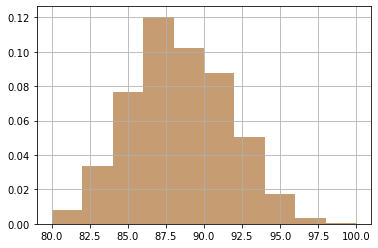

In [82]:
# Идеальное совпадение 

x = y_train.hist(density = True, alpha = 0.5)
y = y_test.hist(density = True, alpha = 0.5)

In [83]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer()

In [84]:
train = tfidf.fit_transform(x_train.description)

In [85]:
test = tfidf.transform(x_test.description)

In [87]:
df.describe()

,points,price,country_cat,winery_cat,variety_cat,region_2_cat,region_1_cat
count,150925.000000,150925.000000,150925.000000,150925.000000,150925.000000,150925.000000,150925.000000
mean,87.888527,33.705668,29.482968,7662.680225,317.336379,3.048945,520.662972
std,3.222290,34.744006,15.017208,4272.075735,182.583897,5.003157,408.515126
min,80.000000,4.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,86.000000,16.000000,15.000000,4265.000000,110.000000,0.000000,122.000000
50%,88.000000,25.000000,33.000000,7904.000000,402.000000,0.000000,531.000000
75%,90.000000,40.000000,44.000000,11393.000000,445.000000,4.000000,909.000000
max,100.000000,2300.000000,47.000000,14808.000000,631.000000,18.000000,1236.000000


In [88]:
train

<105647x28370 sparse matrix of type '<class 'numpy.float64'>'
	with 2576601 stored elements in Compressed Sparse Row format>

In [89]:
from scipy.sparse import hstack

new_columns_train = np.array(x_train[['country_cat', 'price','region_1_cat', 
                                  'region_2_cat', 'variety_cat', 'winery_cat']])


new_columns_test = np.array(x_test[['country_cat', 'price','region_1_cat', 
                                  'region_2_cat', 'variety_cat', 'winery_cat']])

In [90]:
train_2 = hstack([train, new_columns_train])
test_2 = hstack([test, new_columns_test])

## Лес

In [91]:
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier

In [92]:
rf = RandomForestRegressor(n_estimators=30, 
                           max_depth=10)
rf.fit(train_2, y_train)

RandomForestRegressor(max_depth=10, n_estimators=30)

In [93]:
y_prediction = rf.predict(test_2)

In [94]:
from sklearn.metrics import mean_squared_error

# RMSE
np.sqrt(mean_squared_error(y_prediction,y_test))

2.241226475129356

In [95]:
np.sqrt(mean_squared_error(rf.predict(train_2),y_train))

2.1753087713095822

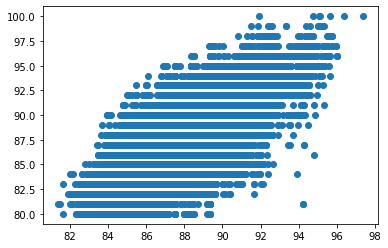

In [96]:
plt.scatter(y_prediction,y_test)

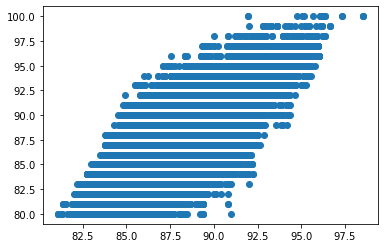

In [97]:
plt.scatter(rf.predict(train_2),y_train)

## Ошибка out-of-bag

Конкретно при обучении случайного леса для проверки качества модели не обязательно отделять тестовую выборку. Поскольку каждое дерево леса обучается на бутстрапированной псевдовыборке, часть объектов не попадает в обучение, а значит дерево эти объекты "не видит". 
Ошибка out-of-bag - это средняя ошибка для каждого наблюдения $z$, которая рассчитывается с использованием прогнозов деревьев, не содержащих $z$ в их обучающей выборке. Это позволяет обучать и тестировать RandomForestClassifier одновременно. Ниже показаны графики зависимости ошибки OOB от количества деревьев во время обучения. Иногда таким образом можно подбирать оптимальное значение n_estimators, при котором ошибка стабилизируется.

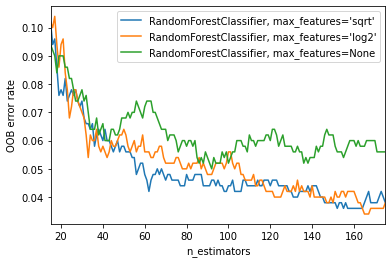

In [98]:
from collections import OrderedDict
from sklearn.datasets import make_classification
from sklearn.ensemble import RandomForestClassifier

RANDOM_STATE = 14

# Генерируем данные для классификации
X, y = make_classification(n_samples=500, n_features=25,
                           n_clusters_per_class=1, n_informative=15,
                           random_state=RANDOM_STATE)


# Здесь выставлен параметр `warm_start`
# он мешает лесу обучаться параллельно, но необходим для мониторинга ошибки OOB во время обучения
ensemble_clfs = [
    ("RandomForestClassifier, max_features='sqrt'",
        RandomForestClassifier(warm_start=True, oob_score=True,
                               max_features="sqrt", # Берем корень от кол-ва признакова
                               random_state=RANDOM_STATE)),
    
    ("RandomForestClassifier, max_features='log2'",
        RandomForestClassifier(warm_start=True, 
                               max_features='log2',  # Берем log2 от кол-ва признакова
                               oob_score=True,
                               random_state=RANDOM_STATE)),
    
    ("RandomForestClassifier, max_features=None",
        RandomForestClassifier(warm_start=True, max_features=None,
                               oob_score=True,
                               random_state=RANDOM_STATE))
]

# Деламе словарь: "Название модели" -> (<n_estimators>, <error rate>)
error_rate = OrderedDict((label, []) for label, _ in ensemble_clfs)

# Интервал для `n_estimators`
min_estimators = 15
max_estimators = 175

for label, clf in ensemble_clfs:
    for i in range(min_estimators, max_estimators + 1):
        clf.set_params(n_estimators=i)
        clf.fit(X, y)

        # Записываем ошибку OOB для каждого значения `n_estimators=i`.
        oob_error = 1 - clf.oob_score_
        error_rate[label].append((i, oob_error))

# График "OOB error rate" от "n_estimators"
for label, clf_err in error_rate.items():
    xs, ys = zip(*clf_err)
    plt.plot(xs, ys, label=label)

plt.xlim(min_estimators, max_estimators)
plt.xlabel("n_estimators")
plt.ylabel("OOB error rate")
plt.legend(loc="upper right")
plt.show()

## KFold (обычный или стратифицированный)

[**кросс - валидация**](https://en.wikipedia.org/wiki/Cross-validation_(statistics)). Исходные данные делятся на $k$ фолдов примерно одинакового размера. Затем на $(k - 1)$ блоке производится обучение модели, а оставшаяся часть используется для тестирования. Процедура повторяется $k$ раз, при этом на каждом проходе для проверки выбирается новый блок, а обучение производится на оставшихся.

*Преимущества*: распределение классов оказывается более равномерным, что улучшает качество обучения, оценка является более надежной.
   
*Недостаток*: обучение модели происходит $k$ раз.

Для разбиения выборки на $k$ частей можно воспользоваться методом[`KFold()`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html) из библиотеки `sklearn.model_selection`. В данной библиотеке также существует метод [`StratifiedKFold()`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedKFold.html), который производит стратифицированное разделение выборки на фолды. Кроме того, можно воспользоваться методом [`cross_val_score()`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html), который принимает на вход выбранный алгоритм построения и сразу выдает результаты.


Выбор $k$ зависит от объема выборки.

<img src="https://brettromero.com/wp-content/uploads/2016/05/cross-validation-639x350.png">

In [99]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

# Линейная регрессия
from sklearn.linear_model import LinearRegression

# Данные об автомобилях
data_set = 'auto-mpg.csv'

# Читаем
data = pd.read_csv(data_set)

# Смотрим
data.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,model year,origin,car name
0,18.0,8,307.0,130,3504,12.0,70,1,chevrolet chevelle malibu
1,15.0,8,350.0,165,3693,11.5,70,1,buick skylark 320
2,18.0,8,318.0,150,3436,11.0,70,1,plymouth satellite
3,16.0,8,304.0,150,3433,12.0,70,1,amc rebel sst
4,17.0,8,302.0,140,3449,10.5,70,1,ford torino


In [100]:
X = data[['cylinders','weight']]
y = data['mpg']

# Разбиваем на train/test
X_train,X_test,y_train,y_test = train_test_split(X,y)

# KFold  на 5 фолдов
kf = KFold(n_splits=5,shuffle=True, random_state=123)

# Для кросс-валидации мы разбиваем датасет на n частей (сейчас на 5) и прогоняем тест с перемешиванием
# (Shuffle=True) на каждом. 'random_state' добавлен для воспроизводимости
lr = LinearRegression()

# Считаем качество на кросс-валидации k-folds. За разбиение отвечает аргумент 'cv' 
cv_scores = cross_val_score(lr,X_train,y_train,cv=kf, scoring = 'neg_root_mean_squared_error')
cv_scores

array([-5.09130767, -4.31575177, -3.96608877, -4.57953741, -4.74883736])

In [101]:
kf = KFold(n_splits=10, shuffle=True, random_state=123)
cv_scores = cross_val_score(lr,X_train,y_train,cv=kf,scoring = 'neg_root_mean_squared_error')
cv_scores

array([-5.01839508, -5.1684949 , -4.45616106, -4.12761664, -3.84215904,
       -4.0548503 , -4.02732948, -5.06187383, -5.52865283, -3.86165121])

In [102]:
# В конце полученные на кросс-валидации скоры можно усреднить для более робастной оценки качества
cv_scores.mean()

-4.514718437683659

## [Leave-one-out](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.LeaveOneOut.html?highlight=leaveoneout#sklearn.model_selection.LeaveOneOut)

Это особый вид KFold стратификации, где каждое наблюдение используется один раз в качестве тестовой выборки, а остальные – В качестве обучающей.

**LeaveOneOut()** эквивалентен **KFold (n_splits = n)** и **LeavePOut (p = 1)**, где **n** - количество наблюдений.

Из-за очень большого количества наборов тестов (которое равно количеству наблюдений) такой метод кросс-валидации может быть очень дорогостоящим. Для больших наборов данных следует отдавать предпочтение **KFold**, **ShuffleSplit** или **StratifiedKFold**.

## Train/test/validation для сравнения моделей или подбора гиперпараметров

In [103]:
import xgboost as xgb

In [104]:
names = ['price','country_cat','winery_cat','variety_cat','region_2_cat','region_1_cat']

df_xgb = df[names].copy()
y_xgb = df['points'].copy()

In [105]:
x_train, x_test, y_train, y_test = train_test_split(df_xgb, 
                                                    y_xgb, 
                                                    test_size = 0.2,
                                                    stratify = y_xgb, # Удостоверились, что доля одинаковая
                                                    random_state = 14)

In [106]:
x_train, x_validation, y_train, y_validation = train_test_split(x_train, 
                                                    y_train, 
                                                    test_size = 0.2,
                                                    stratify = y_train, # Удостоверились, что доля одинаковая
                                                    random_state = 14)

In [107]:
xgb_train = xgb.DMatrix(x_train[names], y_train,
                        feature_names = names, enable_categorical=True)

xgb_validation = xgb.DMatrix(x_validation[names], y_validation, 
                             feature_names = names, enable_categorical=True)

xgb_test = xgb.DMatrix(x_test[names], y_test, 
                             feature_names = names, enable_categorical=True)

In [114]:
xgb_params = {
    'eta': 0.1,
    'max_depth': 6,
    'subsample': 0.7,
    'colsample_bytree': 0.7,
    'objective': 'reg:linear',
    'eval_metric': 'rmse',
    'min_child_weight':1,
    'lambda': 2,
    'silent': 1,
    'seed':15
}

In [115]:
evallist = [(xgb_validation, 'eval'), (xgb_train, 'train')]

In [116]:
model = xgb.train(params = xgb_params, 
                    dtrain = xgb_train, 
                    num_boost_round =1000, 
                    evals = evallist, 
                    early_stopping_rounds = 10, 
                    verbose_eval = 50
                   )

[10:21:29] WARNING: /Users/travis/build/dmlc/xgboost/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[10:21:29] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	eval-rmse:78.71629	train-rmse:78.71601
[50]	eval-rmse:2.47346	train-rmse:2.45425
[100]	eval-rmse:2.38120	train-rmse:2.34378
[150]	eval-rmse:2.34310	train-rmse:2.29078
[200]	eval-rmse:2.31644	train-rmse:2.25149
[250]	eval-rmse:2.29561	train-rmse:2.21747
[300]	eval-rmse:2.27861	train-rmse:2.18913
[350]	eval-rmse:2.26332	train-rmse:2.16375
[400]	eval-rmse:2.25054	train-rmse:2.14078
[450]	eval-rmse:2.23925	train-rmse:2.11818
[500]	eval-rmse:2.22816	train-rmse:2.09809
[550]	eval-rmse:2.21732

In [117]:
predictions = model.predict(xgb_test)

In [118]:
# RMSE на тестовой выборке

np.sqrt(mean_squared_error(predictions,y_test))

2.1401471722447805

# Регуляризация

Мы с вами уже сталкивались с обоими этими понятиями, но они являются чрезвычайно важными, поэтому о них стоит поговорить отдельно. Как вы понимаете, один из крайне важных пунктов в машинном обучении - необходимость избегать  переобучения. Индикатором переобучения будет то, что ваша модель на обучающей выборке будет иметь хорошее значение метрики качества, а на тестовой - плохое. Так происходит из за того, что ваша модель слишком сильно "переподгоняется" под обучающую выборку, в том числе - под содержащийся в ней случайный шум. 

Как это обычно работает: без регуляризации многие модели после длительного обучения начинают считать не слишком важные признаки важными и подгоняются под конкретные наблюдения из обучающей выборки (ведь наша цель при обучении - найти такие параметры, чтобы ошибка на обучающей выборке была минимальна). Чтобы избежать этого, нам нужно налодить некоторые ограничения на сложность нашей модели.

**Модель переподгоняется под точки:**
<img src = "https://miro.medium.com/max/1520/1*u2MTHaUPMJ8rkTYjm2nHww.gif">

## Как выглядит регуляризация

Мы с вами встречали два вида регуляризации: **L1** (или Lasso) и **L2** (или Ridge)

Для линейной регрессии в оба вида регуляризации в явном виде включаются коэффициенты. Если наша линейная регрессия имеет вид:
$$
a(\mathbf{x}_{i}) = \Big(\mathbf{w}, \mathbf{x}_{i}\Big), \quad i = \overline{1, n}.
$$

Нашей задачей было найти коэффициенты $w_{j}, j = \overline{0, m}$, которые доставляют минимум некоторому функционалу ошибки $Q(a, \mathbf{X})$:

$$
Q(a, \mathbf{X}) \to \min_{a},
$$
где $\mathbf{X}$ - матрица, строками которой является векторы $\mathbf{x}_{i}$.

Наша задача поиска минимума сводится к следующей:

$$
Q(\mathbf{w}, \mathbf{X}) \to \min_{\mathbf{w}}
$$

### L2-регуляризация для линейной регрессии

Этот вид регуляризации "штрафует" модель за слишком большие значения весов $w_{j}, j = \overline{0, m}$ с помощью добавления в функционал ошибки суммы квадратов весов.
$$
Q_{L_{2}}(\mathbf{w}, \mathbf{X}) = Q(\mathbf{w}, \mathbf{X}) + \lambda\sum\limits_{j = 1}^{m}w_{j}^{2} = \lambda||\mathbf{w}||_{L_{2}}^{2}.
$$

За счет явного добавления весов как параметров в наш функционал ошибки при его минимизации происходит и уменьшение модулей самих весов, а значит мы снижаем вероятность, что какие-то признаки будут давать слишком большой вклад в модель за счет больших коэффициентов перед ними. Итоговые коэффициенты модели теперь оцениваются с помощьью минимизации модифицированного функционала. Здесь $\lambda$ - гиперпараметр, который определяет, насколько сильно мы хотим штрафовать модель. Гиперпараметрами называют такие параметры, значения которых не оптимизируются в процессе построения модели. Они настраиваются заранее, а для того, чтобы подобрать их оптимальные значения, нужно многократно обучить модели на разных значениях гиперпараметров и выбирать оптимальное. Таким образом квадратичная регуляризация снижает риск переобучения за счет штрафа за "сложность" модели. Отдельно стоит сказать, что в добавляемую к функционалу ошибки сумму квадратов не входит квадрат свободного члена $w_0$. Он является мерой среднего значения целевой переменной, когда все признаки равны 0. Явным плюсом является то, что такая добавка в функционал ошибки является дифференцируемой.

Обсуждая линейную регрессию, мы говорили, что признаки для нее неплохо стандартизировать перед обучением модели, но в действительности коэффициенты, полученные с помощью стандартной линейной регрессии без регуляризатора с квадратичным функционалом ошибки масштабно инвариантны, то есть если мы каждый входной параметр умножим на $c$, то соответствующие коэффициенты масштабируются с коэффициентом $1 /c$. Следовательно, независимо от того, как масштабируется предиктор, произведение предиктора и коэффициента остается неизменным. Для регрессии с регуляризатором это не так, поэтому нам необходимо стандартизировать предикторы или каким-либо другим способом (например минимаксным преобразованием) привести предикторы к той же шкале, прежде чем строить саму регрессию.

### L1-регуляризация для линейной регрессии

Этот вид регуляризации "штрафует" модель за слишком большие значения весов $w_{j}, j = \overline{0, m}$ с помощью добавления в функцию ошибки суммы модулей весов.
$$
Q_{L_{1}}(\mathbf{w}, \mathbf{X}) = Q(\mathbf{w}, \mathbf{X}) + \lambda\sum\limits_{j = 1}^{m}|w_{j}| = \lambda||\mathbf{w}||_{L_{1}},
$$

В математике выражение с суммой модулей известно как L1-норма. Этот вид регуляризации "меньше штрафует" модель за большие веса, но у $L1$ для линейной регрессии есть полезное свойство - такой вид регуляризации обнуляет коэффициенты перед малоинформативными признаками (мы это не будем доказывать), но знать об этом точно стоит. Перед применением регрессии с L1-регуляризатором также необходимо шкалировать признаки (например стандартизовать или сделать минимаксное преобразование). 

На описанные методы можно также взглянуть немного с другой точки зрения. Регрессию с $L2$-регуляризацией можно рассматривать как решение уравнения, в котором сумма квадратов коэффициентов меньше или равна $s$. А $L1$ можно рассматривать как уравнение, в котором сумма модулей коэффициентов меньше или равна $s$. Здесь $s$ - число, которая можно отыскать для каждого значения коэффициента регуляризации $\lambda$ . Эти уравнения также называются функциями ограничений. Большое количество параметров мы можем представить себе на графике с трудом, поэтому представим, что в задаче регрессии параметра всего два ($\beta_1$ и $\beta_2$):

Тогда, согласно приведенной выше формулировке, регрессия с $L2$-регуляризацией выражается как $\beta_1^2 + \beta_2^2 \le s$ . Это означает, что коэффициенты такой регрессии имеют наименьшее значение функции потерь для всех точек, лежащих в пределах круга $\beta_1^2 + \beta_2^2 \le s$.
Аналогично, для $L1$-регуляризации уравнение принимает вид: $|\beta_1| + |\beta_2| \le s$. Это означает, что коэффициенты такой регрессии имеют наименьшее значение функции потерь для всех точек, лежащих в пределах ромба, задаваемого формулой $|\beta_1| + |\beta_2| \le s$.

<img src = "https://miro.medium.com/max/1400/1*XC-8tHoMxrO3ogHKylRfRA.png">


### ElasticNet для линейной регрессии

Вы уже поняли, что в Data Science люди любят придумывать различные названия, вот вам еще одно. Если вы решили к своему функционалу ошибки добавить оба вида регуляризации (и $L1$ и $L2$), каждый со своим коэффициентом, такая регрессия будет называться *ElasticNet*-регрессией.

Несмотря на то, что примеры были приведены для случая задачи регрессии, заметьте, что функционал ошибки $Q_{L_{1}}(\mathbf{w}, \mathbf{X})$ вполне может быть функционалом и для задачи классификации - способ добавления в него штрафа за большие коэффициенты не изменится никак. Значит регуляризовать можно и логистическую регрессию тоже :) да и любые другие линейные модели. 


## Что нужно понять из рисунка с красными эллипсами

На рисунке показаны ограничения регуляризации (зеленые области) для $L1$ (слева) и $L2$ (справа), а также контуры для суммы квадратов отклонений (красный эллипс). Здесь подразумевается, что функция ошибки - средний квадрат отклонения. Для очень большого значения $s$ зеленые области будут содержать центр эллипса, что делает оценки коэффициентов обоих методов регрессии равными оценкам для регрессии без регуляризатора. На изображении выше это не так. В этом случае оценки коэффициентов регрессий $L1$ и $L2$ задаются первой точкой, в которой красный эллипс соприкасается с областью ограничения. Поскольку $L2$ имеет ограничение в форме круга без острых углов, это пересечение обычно не происходит на оси, и поэтому оценки коэффициентов для $L2$-регрессии будут ненулевыми. Однако ограничение для $L1$ имеет углы на каждой из осей, поэтому эллипс будет часто пересекать область ограничения по оси. Когда это происходит, один из коэффициентов (соответствующий этой оси) обнуляется. При большем количестве признаков (больше чем 2), многие из коэффициентов могут одновременно равняться нулю (то самое обнуление при малоинформативных признаках).

Все это означает, что $L2$-регуляризация помогает "понизить вес" малоинформативных признаков, но не обнуляет их (отбирать признаки уж точно нужно отдельно), а $L1$-регуляризация при достаточно большом коэффициенте регуляризации осуществляет отбор признаков, однако неплохо, если часть малоинформативных признаков (например с низкой корреляцией с таргетом для классификации или, например, очень низким weight of evidence для классификации вы отбросите).

# Пример из scikit-learn

In [195]:
train = pd.read_csv("train_houses_reg.csv")
test = pd.read_csv("test_houses_reg.csv")

In [196]:
train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [197]:
train.shape, test.shape

((1460, 81), (1459, 80))

In [198]:
all_data = pd.concat((train.loc[:,'MSSubClass':'SaleCondition'],
                      test.loc[:,'MSSubClass':'SaleCondition']))

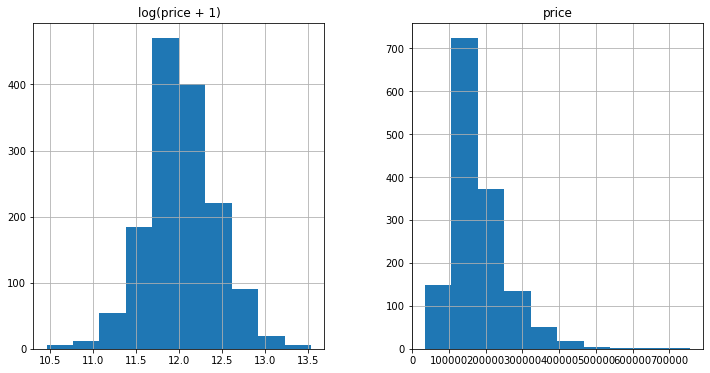

In [199]:
import matplotlib

matplotlib.rcParams['figure.figsize'] = (12.0, 6.0)
prices = pd.DataFrame({"price":train["SalePrice"], "log(price + 1)":np.log1p(train["SalePrice"])})
p = prices.hist()

Преобразуем [скошенные](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.skew.html) переменные

In [200]:
from scipy.stats import skew

# преобразуем таргет:
train["SalePrice"] = np.log1p(train["SalePrice"])

# Преобразуем все признаки со скошенностью:
numeric_feats = all_data.dtypes[all_data.dtypes != "object"].index

skewed_feats = train[numeric_feats].apply(lambda x: skew(x.dropna())) #compute skewness
skewed_feats = skewed_feats[skewed_feats > 0.75]
skewed_feats = skewed_feats.index

all_data[skewed_feats] = np.log1p(all_data[skewed_feats])

In [201]:
all_data = pd.get_dummies(all_data)

In [202]:
X_train = all_data[:train.shape[0]]
X_test = all_data[train.shape[0]:]
y = train.SalePrice

In [203]:
# Пропуски заполним средним:
X_train = X_train.fillna(X_train.mean())
X_test = X_test.fillna(X_train.mean())

In [204]:
from sklearn.linear_model import Ridge, RidgeCV, ElasticNet, LassoCV

def rmse_cv(model):
    rmse= np.sqrt(-cross_val_score(model, X_train, y, scoring="neg_mean_squared_error", cv = 5))
    return(rmse)

In [205]:
model_ridge = Ridge()

In [206]:
alphas = [0.05, 0.1, 0.3, 0.5, 1, 3, 5, 10, 15, 20, 25, 30, 40, 50]
cv_ridge = [rmse_cv(Ridge(alpha = alpha)).mean() 
            for alpha in alphas]

Text(0, 0.5, 'rmse')

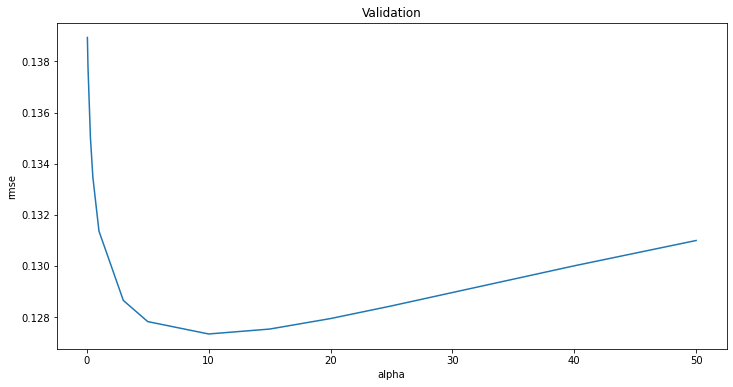

In [207]:
cv_ridge = pd.Series(cv_ridge, index = alphas)
cv_ridge.plot(title = "Validation")
plt.xlabel("alpha")
plt.ylabel("rmse")

In [208]:
cv_ridge.min()

0.12733664928776994

In [209]:
model_lasso = LassoCV(alphas = [1, 0.1, 0.001, 0.0005]).fit(X_train, y)

In [210]:
rmse_cv(model_lasso).mean()

0.12256909294467

Кроме того, мы обсудили, что Лассо-регрессия умеет обнулять коэффициенты

In [211]:
coef = pd.Series(model_lasso.coef_, index = X_train.columns)

In [212]:
print("Lasso отобрало " + str(sum(coef != 0)) + " переменных и отбросило " +  str(sum(coef == 0)) + " переменных")

Lasso отобрало 110 переменных и отбросило 178 переменных


# А что же делать с деревьями?

### Деревья

Для деревьев и лесов так явно включить веса в регуляризацию не получится. Тут нам придется по-другому штрафовать модель за сложность. Что такое сложность дерева? По сути, дерево может идеально разделить абсолютно любую выборку (достаточно чтоб в каждом листе остался один объект), а значит для регуляризации дерева нам надо или осуществлять "стрижку" дерева после его построения (см. лекцию про деревья и ссылку на алгоритм CART) или заранее предотвратить переподгонку, ограничив количество объектов в листе, а также ограничив глубину дерева. В действительности, эти величины являются гиперпараметрами нашего алгоритма, точно такими же, как коэффициенты при регуляризаторах в линейной регрессии, и подбирать их нужно отдельно. 


### Леса
Хорошо, с деревьями разобрались, а что делать с лесами. Во-первых для регуляризации лесов можно использовать те же методы, что и для обычных деревьев. Кроме того, у нас есть возможность подбирать еще два регуляризующих гиперпараметра:

* Из какого процента наблюдений генерируется бутстрап-выборка для обучения нового дерева

* На каком проценте признаков это дерево будет обучаться

По сути, оба параметра направлены на "загрубление" оценки и предотвращение "переподгонки" каждого дерева под выборку. Кроме того, мы ожидаем, что при усреднении прогнозов разных деревьев ответ получится более точным (здесь нам важно, чтобы при построения леса деревья не оказывались одинаковыми, иначе мы потеряем все преимущества леса перед обычными деревьями)

### Градиентный бустинг

В градиентном бустинге мы строим деревья подряд, последовательно пытаясь уменьшить ошибку. Здесь риск переобучения крайне велик. Первый параметр, который используется для регуляризации, это $\eta$ - вклад каждого следующего дерева. С помощью него мы не даем бустингу "слишком сильно корректировать ошибку", но это не единственное, на что бустинг способен. Вы могли заметить, что при обучении бустинга также есть возможность включать $L_1$- или $L_2$-регуляризацию. Но откуда, там же нет весов?

<img src = "https://miro.medium.com/max/1400/1*F7oim6JAbEHGB9-wrU6TfA.png" width= 700>

Бустинг обучает деревья последовательно, причем каждое следующее обучается на "ошибку", оставшуюся от предыдущих. Почему бы нам не взять и не "регуляризовать" этот остаток в явном виде.

<img src = "https://miro.medium.com/max/982/1*8Q4PFBRPrc0qqM00odeKQA.png" width= 500>

Вот [тут](https://albertum.medium.com/l1-l2-regularization-in-xgboost-regression-7b2db08a59e0) можно прочитать про то, как конкретно в xgboost'e выглядит регуляризация, как здесь использовано разложение в ряд Тейлора.

**DISCLAIMER:** *Особенные любители показать свою образованность раньше любили спрашивать такое на собеседованиях*

**P.S.:** *Надеюсь, что это издевательство прекратилось*

По статье выше можно разобраться, зачем все-таки в XGBoost вторая производная

In [222]:
xgb_train = xgb.DMatrix(x_train[names], y_train,
                        feature_names = names, enable_categorical=True)

xgb_validation = xgb.DMatrix(x_validation[names], y_validation, 
                             feature_names = names, enable_categorical=True)

xgb_test = xgb.DMatrix(x_test[names], y_test, 
                             feature_names = names, enable_categorical=True)

In [223]:
xgb_params = {
    'eta': 0.1,
    'max_depth': 6,
    'subsample': 0.7,
    'colsample_bytree': 0.7,
    'objective': 'reg:linear',
    'eval_metric': 'rmse',
    'min_child_weight':1,
    'lambda': 1,
    'silent': 1,
    'seed':15
}

In [224]:
evallist = [(xgb_validation, 'eval'), (xgb_train, 'train')]

In [225]:
for _lambda in np.arange(0.2,1.2,0.2):
    xgb_params['lambda'] = _lambda
    model = xgb.train(params = xgb_params, 
                        dtrain = xgb_train, 
                        num_boost_round =1000, 
                        evals = evallist, 
                        early_stopping_rounds = 10, 
                        verbose_eval = 200
                       )

[11:41:05] WARNING: /Users/travis/build/dmlc/xgboost/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[11:41:05] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	eval-rmse:78.71457	train-rmse:78.71497
[200]	eval-rmse:2.31233	train-rmse:2.23794
[400]	eval-rmse:2.24642	train-rmse:2.12096
[600]	eval-rmse:2.20035	train-rmse:2.03399
[800]	eval-rmse:2.17081	train-rmse:1.96804
[999]	eval-rmse:2.14359	train-rmse:1.90950
[11:41:26] WARNING: /Users/travis/build/dmlc/xgboost/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[11:41:26] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:541: 
Parameters: { 

In [227]:
xgb_params = {
    'eta': 0.1,
    'max_depth': 6,
    'subsample': 0.7,
    'colsample_bytree': 0.7,
    'objective': 'reg:linear',
    'eval_metric': 'rmse',
    'min_child_weight':1,
    'lambda': 0.2,
    'silent': 1,
    'seed':15
}

model = xgb.train(params = xgb_params, 
                    dtrain = xgb_train, 
                    num_boost_round =1000, 
                    evals = evallist, 
                    early_stopping_rounds = 10, 
                    verbose_eval = 200
                   )

[11:45:27] WARNING: /Users/travis/build/dmlc/xgboost/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[11:45:27] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	eval-rmse:78.71457	train-rmse:78.71497
[200]	eval-rmse:2.31233	train-rmse:2.23794
[400]	eval-rmse:2.24642	train-rmse:2.12096
[600]	eval-rmse:2.20035	train-rmse:2.03399
[800]	eval-rmse:2.17081	train-rmse:1.96804
[999]	eval-rmse:2.14359	train-rmse:1.90950


In [228]:
predictions = model.predict(xgb_test)

In [229]:
# RMSE на тестовой выборке

np.sqrt(mean_squared_error(predictions,y_test))

2.1250509963979987